In [6]:
import keras
from src.ParticleNet.EdgeConvLayer import EdgeConvLayer
from src.ParticleNet.PointNet import PointNetLayer
from src.ParticleNet.GlobalPooling import GlobalAveragePoolingLayer
from utilities import utilities
from ML.ParticleCloud.data_loaders import load_data_qg_tagging

#### Loading the Data

In [7]:
X_train, y_train = load_data_qg_tagging(quark_data_path="../../../Data/Trainning/q_jets.csv", gluon_data_path="../../../Data/Trainning/g_jets.csv")
X_val, y_val = load_data_qg_tagging(quark_data_path="../../../Data/Validation/q_jets.csv", gluon_data_path="../../../Data/Validation/g_jets.csv")

In [8]:
print(f"Size of the Training set: {len(X_train)}")
print(f"Size of the Validation set: {len(X_val)}")

Size of the Training set: 251379
Size of the Validation set: 44362


In [9]:
X_train.shape

(251379, 30, 5)

#### Setting up the NN

In [14]:
# MLP for the edge conv layer
mlp_edg_conv = keras.Sequential([
    keras.layers.InputLayer(shape=[8]),
    keras.layers.Dense(32),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(32),
    keras.layers.LeakyReLU()
])

# MLP for the Point-Net NN
mlp_jets = keras.Sequential([
    keras.layers.InputLayer(shape=[4]),
    keras.layers.Dense(32),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(32),
    keras.layers.LeakyReLU()
])

# input layer for the PointNet and ParticleCloud
input_layer = keras.layers.Input(shape=(30, 5))
# Point-Net
point_net_layer = PointNetLayer(mlp=mlp_jets, output_dim=32)(input_layer)
pooling_pb = GlobalAveragePoolingLayer()(point_net_layer)
# Particle Cloud
edge_conv_layer = EdgeConvLayer(mlp=mlp_edg_conv, mlp_output_dim=32, final_index_coord=2, max_number_particles=30, k_neighbors=4)(input_layer)
pooling_particle_cloud = GlobalAveragePoolingLayer()(edge_conv_layer)

# Joinning the two models
concatenated_models = keras.layers.Concatenate()([pooling_pb, pooling_particle_cloud])

# addding more layers that receives the PointNet and ParticleCloud as inputs
hidden_layer = keras.layers.Dense(64, activation='leaky_relu')(concatenated_models)
dropout = keras.layers.Dropout(rate=0.1)(hidden_layer)
hidden_layer = keras.layers.Dense(64, activation='leaky_relu')(dropout)
dropout = keras.layers.Dropout(rate=0.1)(hidden_layer)
final_layer = keras.layers.Dense(2, activation='softmax')(dropout)

# Create the final model
model = keras.Model(inputs=input_layer, outputs=final_layer)

# Print the model summary
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 30, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ point_net_layer_2   │ (None, 30, 33)    │      1,216 │ input_layer_8[0]… │
│ (PointNetLayer)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ edge_conv_layer_2   │ (None, 30, 33)    │      1,344 │ input_layer_8[0]… │
│ (EdgeConvLayer)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ point_net_layer_… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ edge_conv_layer_… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64)        │      4,160 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │      4,160 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 2)         │        130 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,010 (43.01 KB)

 Trainable params: 11,010 (43.01 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', "auc"])

In [16]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val))   

Epoch 1/100
Instructions for updating:
Use fn_output_signature instead
3928/3928 ━━━━━━━━━━━━━━━━━━━━ 45s 11ms/step - accuracy: 0.7326 - auc: 0.8068 - loss: 0.5337 - val_accuracy: 0.7699 - val_auc: 0.8520 - val_loss: 0.4793
Epoch 2/100
3928/3928 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - accuracy: 0.7683 - auc: 0.8483 - loss: 0.4842 - val_accuracy: 0.7753 - val_auc: 0.8586 - val_loss: 0.4696
Epoch 3/100
3928/3928 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.7711 - auc: 0.8522 - loss: 0.4786 - val_accuracy: 0.7736 - val_auc: 0.8590 - val_loss: 0.4724
Epoch 4/100
3928/3928 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.7766 - auc: 0.8578 - loss: 0.4707 - val_accuracy: 0.7742 - val_auc: 0.8547 - val_loss: 0.4751
Epoch 5/100
3928/3928 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - accuracy: 0.7782 - auc: 0.8593 - loss: 0.4688 - val_accuracy: 0.7911 - val_auc: 0.8694 - val_loss: 0.4541
Epoch 6/100
3928/3928 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.7834 - auc: 0.8635 - loss: 0.4622 - val_accur

In [9]:
# perfoming the prediction
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

7856/7856 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [10]:
print("Trainnig set:")
utilities.display_metrics(y_true=y_train[:, 0], y_pred=y_train_pred[:, 0] > 0.5)
print("Validation set:")
utilities.display_metrics(y_true=y_val[:, 0], y_pred=y_val_pred[:, 0] > 0.5)

Trainnig set:
Recall: 0.8218
Precision: 0.7824
Confusion Matrix:
[[ 99885  28179]
 [ 21972 101343]]
Validation set:
Recall: 0.8201
Precision: 0.7816
Confusion Matrix:
[[17613  4987]
 [ 3915 17847]]


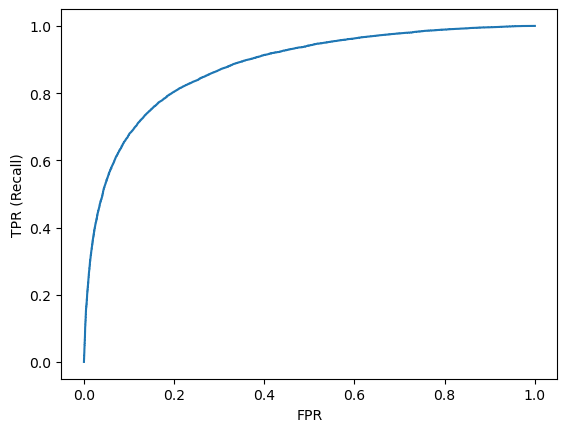

AUC: 0.8800


In [11]:
utilities.display_roc_curve(y_true=y_val[:, 0], y_score=y_val_pred[:, 0])

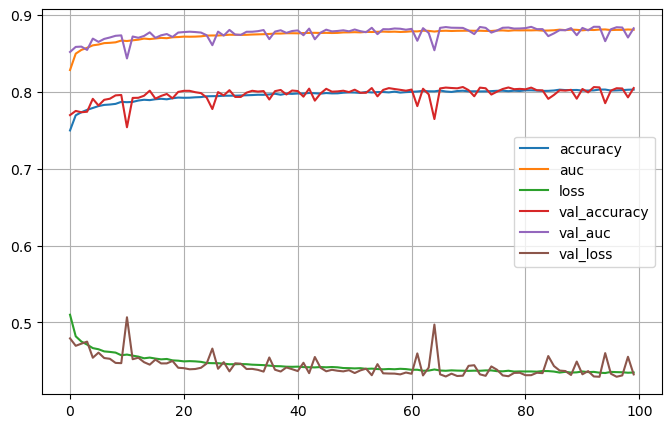

In [17]:
utilities.plot_hist_trainning(history)

In [18]:
utilities.save_model(model, history, "QuarkGluon_Tagging_Combined")